# <span style="color:red">Final Exam - Open Solutions</span>

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# Instructions

## Please note the following:

Points
* You have `100` minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo - you are welcome to use the code posted there without citation.

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

- For Section 1:
    * No data file is needed.
- for Section 2:
    * `data/treasury_quotes_clean_2024-12-31.xlsx`, sheet `selected quotes`.

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 70     |
| 2       | 30     |

***

## Submitting your Exam

Submission
* You will upload your solution to the `Exam - Open` assignment on Canvas. 
* Submit a compressed, "zipped", folder containing all code according to the file structure below.
* Name your submitted, zipped, folder `exam-open-LASTNAME-FIRSTNAME.zip`.
* Be sure to **submit** on Canvas, not just **save** on Canvas.

Your submission should **include all code and data used in your analysis** in the following folder structure.
* We strongly prefer all submissions are structred this way, and it will improve grading accuracy for partial credit. 
* Still, if you're struggling to get this working in time, no worries; just structure as comfortable and submit **everything used** for your submission.

__Exam Submission Structure:__

```plaintext
exam-open-LASTNAME-FIRSTNAME.zip/
│── exam-open.ipynb
│── data/
│   ├── example_data.csv
│── modules/
│   ├── my_functions.py

### Validating your folder structure

The next cell tests that you have this folder structure implemented.

In [1]:
from pathlib import Path
import sys
import pandas as pd

# Get the directory of the notebook (assumes Jupyter Notebook is always used)
BASE_DIR = Path().resolve()

# Define paths for data and modules
DATA_DIR = BASE_DIR / "data"
MODULES_DIR = BASE_DIR / "modules"

# Check if expected directories exist
if not DATA_DIR.exists():
    print(f"Warning: Data directory '{DATA_DIR}' not found. Check your file structure.")

if not MODULES_DIR.exists():
    print(f"Warning: Modules directory '{MODULES_DIR}' not found. Check your file structure.")

# Ensure Python can import from the modules directory
if str(MODULES_DIR) not in sys.path:
    sys.path.append(str(MODULES_DIR))

# Load exam data
EXAMPLE_DATA_PATH = DATA_DIR / "example_data.csv"

if EXAMPLE_DATA_PATH.exists():
    example_data = pd.read_csv(EXAMPLE_DATA_PATH)
else:
    print(f"Warning: '{EXAMPLE_DATA_PATH.name}' not found. Ensure it's in the correct directory.")


### Solutions Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from solution_functions import bond_dirty_price, bond_modified_duration_numerical, bond_modified_convexity_numerical

***

# 1. The "Steepener" Trade

A popular trade in 2024 was the 2s10s "steepener" trade, which was a trade designed to capture the changes in the slope of yield curve while being hedged to parallel shifts in it. In particular, the trade believes that the 2-year treasury yield is too high relative to the 10-year treasury yield. We will replicate this trade.

`Initial date:` July 1st, 2024 (corresponding to $t=0$)

__2-year Bond:__
- `Time To Maturity:` 2 years
- `Coupon Frequency:` semi-annual
- `Coupon Rate:` 4%
- `Annualized semi-annual YTM:` 4.74%

__10-year Bond:__
- `Time To Maturity:` 10 years
- `Coupon Frequency:` semi-annual
- `Coupon Rate:` 2%
- `Annualized semi-annual YTM:` 4.44%

__Note__: Assume that coupons are paid exactly at the $t=0.5, 1, 1.5, ...$ year marks. 

### 1.1. (5pts)
Based on the given information, report the dirty price of each bond as of $t=0$ assuming a face value of $100. Display your answer rounded to 4 decimal places.

<span style="color: red;">
Solution:

In [3]:
# 2-Year
YTM2Y_T0 = 0.0474
TTM2Y_T0 = 2
CPN2Y = 0.04

px_2y_t0 = bond_dirty_price(ytm=YTM2Y_T0, ttm=TTM2Y_T0, coupon_rate=CPN2Y, frequency=2, face_value=100)

# 10-Year
YTM10Y_T0 = 0.0444
TTM10Y_T0 = 10
CPN10Y = 0.02

px_10y_t0 = bond_dirty_price(ytm=YTM10Y_T0, ttm=TTM10Y_T0, coupon_rate=CPN10Y, frequency=2, face_value=100)

px_t0 = pd.DataFrame(index=["2Y", "10Y"], data=[px_2y_t0, px_10y_t0], columns=["px_t0"])

px_t0.round(4)

,px_t0
2Y,98.6037
10Y,80.4684


### 1.2. (5pts)

Report the modified duration and modified-dollar-duration for each bond. Calculate these modified duration values with respect to changes in the quoted semi-annual YTM. Display your answer rounded to 4 decimal places.

<span style="color: red;">
Solution:

In [4]:
# 2-Year Modified Duration
md_2y = bond_modified_duration_numerical(ytm=YTM2Y_T0, ttm=TTM2Y_T0, coupon_rate=CPN2Y, frequency=2, face_value=100)

# 2-Year Modified Dollar Duration
mdd_2y = md_2y * px_2y_t0

# 10-Year Modified Duration
md_10y = bond_modified_duration_numerical(ytm=YTM10Y_T0, ttm=TTM10Y_T0, coupon_rate=CPN10Y, frequency=2, face_value=100)

# 10-Year Modified Dollar Duration
mdd_10y = md_10y * px_10y_t0

dur_t0 = pd.DataFrame(index=["2Y", "10Y"], data=[[md_2y, mdd_2y], [md_10y, mdd_10y]], columns=["md_t0", "mdd_t0"])

dur_t0.round(4)

,md_t0,mdd_t0
2Y,1.8965,187.0042
10Y,8.7875,707.1151


### 1.3. (15pts)
We want to construct our portfolio in a modified-dollar-duration neutral fashion such that we are well hedged to parallel moves in the yield curve. 

Using the results from `1.2`, construct a portfolio aligned with the trade thesis that the YTM spread will converge, and go long one bond and short the other. 

Size the portfolio.
* Your position has a $1,000 (modified duration) exposure to a symmetric 1 basis-point convergence in the YTM spread.
* Assume the spread converges evenly, with 0.5bp convergence on each side.
* We assume no leverage is used. 

Report your position in each bond as:
* the notional amount.
* the market value.
* the number of bond contracts (assuming each contract has a face/par value of $100).

Display your answers rounded to the nearest integer.

<span style="color: red;">
Solution:

In [5]:
# 2Y
target_mdd_1bp = 1_000

mdd_2y_1bp = mdd_2y / 100 / 100

pos_2y_cts = target_mdd_1bp / mdd_2y_1bp
pos_2y_notional = pos_2y_cts * 100
pos_2y_value = pos_2y_cts * px_2y_t0

# 10Y
mdd_10y_1bp = mdd_10y / 100 / 100

pos_10y_cts = -target_mdd_1bp / mdd_10y_1bp
pos_10y_notional = pos_10y_cts * 100
pos_10y_value = pos_10y_cts * px_10y_t0

positions = pd.DataFrame(index=["2Y", "10Y"], data=[[pos_2y_notional, pos_2y_value, pos_2y_cts], [pos_10y_notional, pos_10y_value, pos_10y_cts]], columns=["notional", "market_value", "contracts"])
positions.round(0).astype(int)

,notional,market_value,contracts
2Y,5347472,5272805,53475
10Y,-1414197,-1137981,-14142


### 1.4. (10pts)

Assume we are now at $t=0.05$, and the bond yields have now moved.

__2-year Bond:__
- `Annualized semi-annual YTM:` 4.32%

__10-year Bond:__
- `Annualized semi-annual YTM:` 4.14%

For each bond, report the new dirty price and clean price. Display your answer rounded to 4 decimal places.

<span style="color: red;">
Solution:

In [6]:
# 2-Year
YTM2Y_T1 = 0.0432
TTM2Y_T1 = 1.95

px_2y_t1 = bond_dirty_price(ytm=YTM2Y_T1, ttm=TTM2Y_T1, coupon_rate=CPN2Y, frequency=2, face_value=100)
ai_2y_t1 = (TTM2Y_T0 - TTM2Y_T1) * CPN2Y * 100
clean_2y_t1 = px_2y_t1 - ai_2y_t1

# 2-Year
YTM10Y_T1 = 0.0414
TTM10Y_T1 = 9.95

px_10y_t1 = bond_dirty_price(ytm=YTM10Y_T1, ttm=TTM10Y_T1, coupon_rate=CPN10Y, frequency=2, face_value=100)
ai_10y_t1 = (TTM10Y_T0 - TTM10Y_T1) * CPN10Y * 100
clean_10y_t1 = px_10y_t1 - ai_10y_t1

px_t1 = pd.DataFrame(index=["2Y", "10Y"], data=[[px_2y_t1, ai_2y_t1, clean_2y_t1], [px_10y_t1, ai_10y_t1, clean_10y_t1]], columns=["dirty", "accrued_int", "clean"])
px_t1.round(4)

,dirty,accrued_int,clean
2Y,99.6058,0.2,99.4058
10Y,82.7910,0.1,82.6910


### 1.5. (10pts)

Still at $t=0.05$, report the profit-and-loss **(PnL)** of each position, and also for the entire portfolio, using:
* Duration (first-order YTM changes).

Use the $t=0$ modified-dollar-duration values from part `1.2`. 

Display your answer rounded to 4 decimal places.

<span style="color: red;">
Solution:

In [7]:
# 2Y
pnl_2y_fo = pos_2y_cts * (YTM2Y_T1 - YTM2Y_T0) * -mdd_2y

# 10Y
pnl_10y_fo = pos_10y_cts * (YTM10Y_T1 - YTM10Y_T0) * -mdd_10y

pnl_fo = pd.DataFrame(index=["2Y", "10Y", "Portfolio"], data=[pnl_2y_fo, pnl_10y_fo, pnl_2y_fo + pnl_10y_fo], columns=["first_order"])

pnl_fo.round(4)

,first_order
2Y,42000.0
10Y,-30000.0
Portfolio,12000.0


### 1.6 (10pts)

Repeat `1.5`, but this time uapproximating the PnL using
* Duration + convexity

<span style="color: red;">
Solution:

In [8]:
# 2Y
cvx_2y = bond_modified_convexity_numerical(ytm=YTM2Y_T0, ttm=TTM2Y_T0, coupon_rate=CPN2Y, frequency=2, face_value=100)
cvxd_2y = cvx_2y * px_2y_t0

pnl_2y_so = pos_2y_cts * ((YTM2Y_T1 - YTM2Y_T0) * -mdd_2y + 0.5 * (YTM2Y_T1 - YTM2Y_T0) ** 2 * cvxd_2y)

# 10Y
cvx_10y = bond_modified_convexity_numerical(ytm=YTM10Y_T0, ttm=TTM10Y_T0, coupon_rate=CPN10Y, frequency=2, face_value=100)
cvxd_10y = cvx_10y * px_10y_t0

pnl_10y_so = pos_10y_cts * ((YTM10Y_T1 - YTM10Y_T0) * -mdd_10y + 0.5 * (YTM10Y_T1 - YTM10Y_T0) ** 2 * cvxd_10y)

pnl_so = pd.DataFrame(index=["2Y", "10Y", "Portfolio"], data=[pnl_2y_so, pnl_10y_so, pnl_2y_so + pnl_10y_so], columns=["second_order"])

pnl_so.round(4)

,second_order
2Y,42213.2475
10Y,-30445.9020
Portfolio,11767.3455


### 1.7. (5pts)

Repeat `1.5`, but this time calculating the PnL via
* full repricing (using your pricing results from part `1.4`.)

Display the comparison of the PnL across the three methods of `1.5`, `1.6`, and `1.7`.

<span style="color: red;">
Solution:

In [9]:
# 2Y
pnl_2y_full = pos_2y_cts * (px_2y_t1 - px_2y_t0)

# 10Y
pnl_10y_full = pos_10y_cts * (px_10y_t1 - px_10y_t0)

pnl_full = pd.DataFrame(index=["2Y", "10Y", "Portfolio"], data=[pnl_2y_full, pnl_10y_full, pnl_2y_full + pnl_10y_full], columns=["full_reprice"])

pd.concat([pnl_fo, pnl_so, pnl_full], axis=1).round(4)

,first_order,second_order,full_reprice
2Y,42000.0,42213.2475,53584.4765
10Y,-30000.0,-30445.9020,-32847.0706
Portfolio,12000.0,11767.3455,20737.4058


### 1.8 (5 pts)

* What do the results from `1.6` capture that `1.5` does not, and why might this be important to consider?
* For any change in the YTM spread, do we expect the first order P/L estimate to always underestimate or overestimate the second order P/L estimate? Explain your reasoning.

<span style="color: red;">

Solution:

Whereas `1.5` captures only the P/L stemming from the first order changes in yield, `1.6` captures the P/L from second order changes as well (convexity). This reflects the fact that bond prices have a nonlinear relationship to yields. Despite having a duration-neutral portfolio, clearly we do not have a convexity neutral portfolio. In fact, the convexity of our short position in the 10Y is larger (in magnitude) than that of the 2Y position. In a trading context, this is important to consider if yield moves are expected to be substantial, and even more so if the portfolio is frequently rebalanced to be duration-neutral.

This does __not__ imply that the first order estimate will always over or underestimate the second order estimate. It depends not only on the change in the YTM, but which of the legs drove that move. If we assumed that the YTM spread move was driven by symmetric moves in each of the yields, then because we are net short convexity we always expect our first order P/L estimate to always be greater than our second order P/L estimate.

### 1.9 (5pts)

Name two things the results from `1.7` capture that `1.6` does not.

<span style="color: red;">

Solution:

`1.6` captures the first and second order effects of a yield change on bond prices, which should explain the vast majority of the price change *due to yields*. However, `1.6` still does not fully account for the change in yields as there are higher order components that are missing. These are captured by `1.7`. In addition, and more importantly, the second thing captured by `1.7` that is absent from `1.5` and `1.6` is the effect of time on our positions. Not only did yields change, but time passed, which is an important source of returns with bonds.

This is an introductory example to how one might decompose their bond position P/L into duration, convexity, and "theta". There are numerous methods used for P/L attribution in industry, some of which can get quite complex. 

***

# 2. Extracting Curves

Use the selected treasury quotes in the file, `treasury_quotes_clean_2024-12-31.xlsx`, using sheet `selected quotes`.

* Market quotes are provided for treasury securities expiring approximately every six months over the next `7` years.
* You are welcome to assume that they mature at exaclty six-year increments or to use the exact dates.
* Consider the `price` column to represent the dirty mid price.

In [10]:
import pandas as pd
import numpy as np

In [11]:
filepath = '../data/treasury_quotes_clean_2024-12-31.xlsx'
SHEET = 'selected quotes'
quotes = pd.read_excel(filepath,sheet_name=SHEET).set_index('KYTREASNO')
quotes

,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
KYTREASNO,,,,,,,,,,,,,
208073,note,2024-12-31,2023-06-30,2025-06-30,0.495551,0,4.625,100.240638,100.250357,100.245498,0,100.245498,0.041613
208158,note,2024-12-31,2023-12-31,2025-12-31,0.999316,0,4.250,100.025370,100.044656,100.035013,0,100.035013,0.042172
208242,note,2024-12-31,2024-06-30,2026-06-30,1.494867,0,4.625,100.535515,100.566765,100.551140,0,100.551140,0.042566
208332,note,2024-12-31,2024-12-31,2026-12-31,1.998631,0,4.250,100.008215,100.016028,100.012122,0,100.012122,0.042469
207904,note,2024-12-31,2022-06-30,2027-06-30,2.494182,0,3.250,97.654701,97.685951,97.670326,0,97.670326,0.042520
207989,note,2024-12-31,2022-12-31,2027-12-31,2.997947,0,3.875,98.852192,98.887349,98.869770,0,98.869770,0.042838
208075,note,2024-12-31,2023-06-30,2028-06-30,3.496235,0,4.000,98.966035,99.009004,98.987520,0,98.987520,0.043197
208160,note,2024-12-31,2023-12-31,2028-12-31,4.000000,0,3.750,97.755138,97.802013,97.778576,0,97.778576,0.043617
208244,note,2024-12-31,2024-06-30,2029-06-30,4.495551,0,4.250,99.446447,99.493322,99.469884,0,99.469884,0.043856


<span style="color: red;">
Solution functions:

In [12]:
from scipy.optimize import fsolve

def bootstrap_spot_rates(df):
    """
    Bootstraps spot rates from a dataframe of bond information.
    
    :param df: Pandas DataFrame with columns 'price', 'cpn rate', and 'ttm'
    :return: Pandas Series of spot rates indexed by TTM
    """
    # Ensure the DataFrame is sorted by TTM
    df = df.sort_values(by='ttm')
    
    # Initialize a dictionary to store spot rates
    spot_rates = {}

    # Iterate over each bond
    for index, row in df.iterrows():
        ttm, coupon_rate, price = row['ttm'], row['cpn rate'], row['price']
        cash_flows = [coupon_rate / 2] * round(ttm * 2)  # Semi-annual coupons
        cash_flows[-1] += 100  # Add the face value to the last cash flow

        # Function to calculate the present value of cash flows
        def pv_of_cash_flows(spot_rate):
            pv = 0
            for t in range(1, len(cash_flows) + 1):
                if t/2 in spot_rates:
                    rate = spot_rates[t/2]
                else:
                    rate = spot_rate
                pv += cash_flows[t - 1] / ((1 + rate / 2) ** t)
            return pv

        # Solve for the spot rate that sets the present value of cash flows equal to the bond price
        spot_rate_guess = (cash_flows[-1] / price) ** (1/(ttm*2)) - 1
        spot_rate = fsolve(lambda r: pv_of_cash_flows(r) - price, x0=spot_rate_guess)[0]

        # Store the calculated spot rate
        spot_rates[ttm] = spot_rate

    return pd.Series(spot_rates)


In [13]:
def intrate_to_discount(intrate, maturity, n_compound=None):
    
    if n_compound is None:
        discount = np.exp(-intrate * maturity)
    else:
        discount = 1 / (1+(intrate / n_compound))**(n_compound * maturity)

    return discount    

In [14]:
def discount_to_intrate(discount, maturity, n_compound=None):
        
    if n_compound is None:
        intrate = - np.log(discount) / maturity
    
    else:
        intrate = n_compound * (1/discount**(1/(n_compound * maturity)) - 1)    
        
    return intrate

### 2.1. (15pts)

Bootstrap the spot curve. 

For maturity `T=5`, report
* the discount factor
* the semiannually-compounded discount rate
* the continuously-compounded discount rate

Round your answers to four decimal places.

<span style="color: red;">
Solution

In [15]:
quotes_rounded = quotes.copy()
quotes_rounded['ttm'] = quotes_rounded['ttm'].apply(lambda x: round(x*2)/2)

In [16]:
spot_rates_sa = bootstrap_spot_rates(quotes) # Non rounded results 
discount_factors = intrate_to_discount(spot_rates_sa.values, spot_rates_sa.index,n_compound=2)

res = pd.DataFrame(index=spot_rates_sa.index, columns=['discount factor','semi-annual rates','continuous rates'])
res['discount factor'] = discount_factors 
res['semi-annual rates'] = spot_rates_sa
res['continuous rates'] = discount_to_intrate(res['discount factor'],res.index)

res.round(4)

,discount factor,semi-annual rates,continuous rates
0.495551,0.9800,0.0412,0.0408
0.999316,0.9592,0.0421,0.0417
1.494867,0.9392,0.0424,0.0420
1.998631,0.9195,0.0424,0.0420
2.494182,0.9006,0.0424,0.0420
2.997947,0.8808,0.0428,0.0424
3.496235,0.8614,0.0431,0.0427
4.000000,0.8415,0.0436,0.0431
4.495551,0.8230,0.0438,0.0433
4.999316,0.8050,0.0439,0.0434


In [17]:
spot_rates_sa_rounded = bootstrap_spot_rates(quotes_rounded) # Rounded results 
discount_factors_rounded = intrate_to_discount(spot_rates_sa_rounded.values, spot_rates_sa_rounded.index,n_compound=2)

res_rounded = pd.DataFrame(index=spot_rates_sa_rounded.index, columns=['discount factor','semi-annual rates','continuous rates'])
res_rounded['discount factor'] = discount_factors_rounded
res_rounded['semi-annual rates'] = spot_rates_sa_rounded
res_rounded['continuous rates'] = discount_to_intrate(res_rounded['discount factor'],res_rounded.index)

res_rounded.round(4)

,discount factor,semi-annual rates,continuous rates
0.5,0.9798,0.0412,0.0408
1.0,0.9591,0.0421,0.0417
1.5,0.9390,0.0424,0.0420
2.0,0.9194,0.0424,0.0420
2.5,0.9004,0.0424,0.0420
3.0,0.8806,0.0428,0.0424
3.5,0.8611,0.0432,0.0427
4.0,0.8413,0.0437,0.0432
4.5,0.8225,0.0439,0.0434
5.0,0.8047,0.0439,0.0435


In [18]:
discount_to_intrate(.8047,5,2)

0.04393271753604511

### 2.2. (10pts)

Use the bootstrapped spot curves to calculate the forward curves.

For maturity $T_1=5 \rightarrow T_2=5.5$, report
* the forward discount factor.
* the semiannually-compounded forward rate.
* the continuously-compounded forward rate.

Round your answers to four decimal places.

<span style="color: red;">
Solution

In [19]:
forward_discount = (res['discount factor'].shift(-1) / res['discount factor']).dropna()
forward_discount.loc[0] = res['discount factor'].iloc[0]
forward_discount = forward_discount.sort_index()

forward_cont = discount_to_intrate(forward_discount, 0.5)
forward_sa = discount_to_intrate(forward_discount, 0.5, 2)

fwd_res = pd.DataFrame(index=forward_discount.index, columns=['forward discount','semi-annual rate','continuous rate'])
fwd_res['forward discount'] = forward_discount 
fwd_res['semi-annual rate'] = forward_sa
fwd_res['continuous rate'] = forward_cont 

fwd_res.round(4)

,forward discount,semi-annual rate,continuous rate
0.000000,0.9800,0.0409,0.0405
0.495551,0.9788,0.0434,0.0429
0.999316,0.9791,0.0426,0.0421
1.494867,0.9790,0.0428,0.0424
1.998631,0.9794,0.0420,0.0415
2.494182,0.9780,0.0451,0.0446
2.997947,0.9780,0.0451,0.0446
3.496235,0.9769,0.0472,0.0466
4.000000,0.9780,0.0450,0.0445
4.495551,0.9782,0.0446,0.0441


In [20]:
forward_discount_rounded = (res_rounded['discount factor'].shift(-1) / res_rounded['discount factor']).dropna()
forward_discount_rounded.loc[0] = res_rounded['discount factor'].iloc[0]
forward_discount_rounded = forward_discount_rounded.sort_index()

forward_cont_rounded = discount_to_intrate(forward_discount_rounded, 0.5)
forward_sa_rounded = discount_to_intrate(forward_discount_rounded, 0.5, 2)

fwd_res_rnd = pd.DataFrame(index=forward_discount_rounded.index, columns=['forward discount','semi-annual rate','continuous rate'])
fwd_res_rnd['forward discount'] = forward_discount_rounded
fwd_res_rnd['semi-annual rate'] = forward_sa_rounded
fwd_res_rnd['continuous rate'] = forward_cont_rounded

fwd_res_rnd.round(4)

,forward discount,semi-annual rate,continuous rate
0.0,0.9798,0.0412,0.0408
0.5,0.9789,0.0431,0.0426
1.0,0.9790,0.0430,0.0425
1.5,0.9792,0.0425,0.0420
2.0,0.9793,0.0423,0.0419
2.5,0.9781,0.0448,0.0444
3.0,0.9778,0.0454,0.0449
3.5,0.9770,0.0471,0.0466
4.0,0.9777,0.0456,0.0451
4.5,0.9783,0.0443,0.0438


### 2.3. (5pts)

For which maturity ($T_1$ and $T_2$) is the forward rate highest?

<span style="color: red;">
Solution

<Axes: xlabel='T1', ylabel='Rate'>

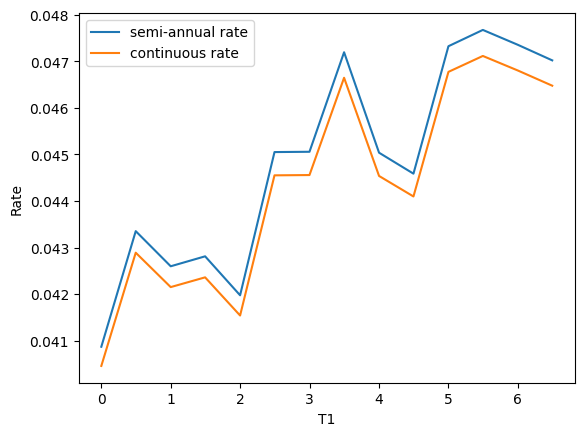

In [21]:
fwd_res[['semi-annual rate','continuous rate']].plot(xlabel='T1',ylabel='Rate')

In [22]:
fwd_res[['semi-annual rate','continuous rate']].idxmax() # (T1, T2) = (5.5, 6)

semi-annual rate    5.494867
continuous rate     5.494867
dtype: float64

***